### Tarea 1: 

Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

In [1]:
#Librerías necesarias

import cv2  
import numpy as np
import matplotlib.pyplot as plt

import random
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

#### Desglose:

1º: Visualizar la imagen e identificar una moneda de la imagen. \
2º: Mostrar por pantalla el número de monedas y cantidad de dinero presente en la imagen.

##### Alternativa 1: findContours()
Búsqueda de contornos general para cualquier figura geométrica (mejor para la tarea 2)

(938, 473, 3)


Text(0.5, 1.0, 'findContours')

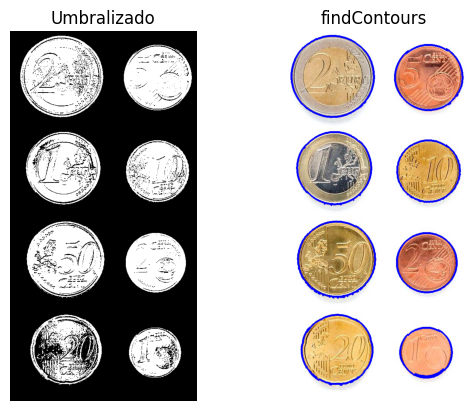

In [2]:
#Carga de la imagen de ejemplo con monedas
img = cv2.imread('Material_P3/Monedas.jpg') 
output = img.copy()
print(img.shape)

#Conversión a RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


#Conversión de la imagen a tonos de gris
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Umbralizado binario invertido
th,img_th = cv2.threshold(img_gris,200,255,cv2.THRESH_BINARY_INV)

#Muestra de la imagen
plt.subplot(121)
plt.axis("off")
plt.imshow(img_th, cmap='grey') 
plt.title('Umbralizado')

#Obtención de los contornos externos
contornos, hierarchy = cv2.findContours(
	img_th, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

#Dibuja sobre la imagen de entrada los contornos en azul (se ve mejor)
#Cada vez que quiere pintar convierte img para no tener restos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,0,255), 3)

plt.subplot(122)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('findContours')



(938, 473)


Text(0.5, 1.0, 'Suavizado')

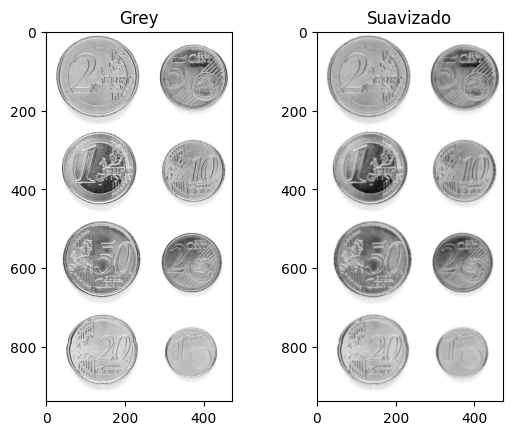

In [3]:
#-------------------------- Alternativa por Transformada de Hough -----------------------


#Reescalado si fuera necesario
height, width = img.shape[:2]

if(height < 800):
      scale = 800/height
      n_height = int(height*scale)
      n_width = int(width*scale)

      output = cv2.resize(img, (n_width, n_height), interpolation=cv2.INTER_CUBIC)
elif (height > 1500):
      scale = 1000/height
      n_height = int(height*scale)
      n_width = int(width*scale)

      output = cv2.resize(img, (n_width, n_height), interpolation=cv2.INTER_CUBIC)

#Conversión a escala de gris
gris = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
print(gris.shape)

plt.subplot(121)
plt.imshow(gris, cmap='grey') 
plt.title('Grey')

#Suavizado (Gaussiano da mejores resultados)
pimg = cv2.GaussianBlur(gris, (5,5), 0)

plt.subplot(122)
plt.imshow(pimg, cmap='grey') 
plt.title('Suavizado')

Text(0.5, 1.0, 'Hough')

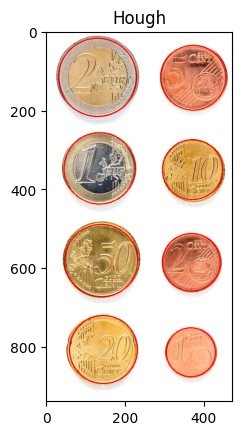

In [4]:
#Hallar círculos mediante el método alternativo de gradiente de Hough (más preciso, más estricto en la selección de parámetros)
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT_ALT,  # tipo de detección
        1.5,
        50,  # distancia mínima entre círculos
        param1=100, # valor del gradiente
        param2=0.9, # umbral acumulador
    )


#Filtro para eliminar duplicados concéntricos
filt_circ = []

# Parámetro de distancia mínima para filtrar centros muy cercanos
dist_umbral = 30

# Filtrar círculos basados en la distancia entre sus centros
for i in range(len(circ[0, :])):
    actual = circ[0, i]
    centro_actual = (actual[0], actual[1])  
    radio_actual = actual[2]
    # Variable para verificar si el círculo es duplicado
    duplicado = False
    # Comparar con los círculos ya filtrados
    for circle in filt_circ:
        centro_filtrado = (circle[0], circle[1])
        # Calcular la distancia entre los centros de los círculos
        distancia = np.linalg.norm(np.array(centro_actual) - np.array(centro_filtrado))
        # Si la distancia es menor que el umbral, consideramos que es un duplicado
        if distancia < dist_umbral:
            duplicado = True
            break
    
    # Si no es un duplicado, agregar el círculo a la lista de filtrados
    if not duplicado:
        filt_circ.append(actual)

for det in filt_circ:
        x_coor, y_coor, det_radio = det
        cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 0, 255), 2)
        cv2.circle(output,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 0, 255), 2)
#Dibujo sobre entrada e imagen vacía
img_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)



#Muestra resultado
plt.plot()
plt.imshow(img_rgb) 
plt.title('Hough')

### Clasificación de monedas
Se procede a clasificar las monedas por diametro y ratio entre las detectadas a partir de los datos obtenidos por transformación de Hough.

Clasificación de monedas

In [5]:
#Ordenar lista por radio de las circunferencias detectadas
s_circ = sorted(filt_circ, key = lambda circle: circle[2], reverse=True)

# Posible alternativa automática (cálculo a partir del mayor radio sin necesidad de hacer click en una moneda de referencia)
#Obtener proporcion
#max_r = s_circ[0][2];
#rat = [(x,y,r, r/max_r) for x,y,r in s_circ]

#Método para comprobar si un valor está cerca de otro dada una tolerancia
def close_val(val, opt1, opt2):
    diff1 = abs(val-opt1)
    diff2 = abs(val-opt2)
    return (diff1 < diff2)

monedas = [
    ("two_euro", 25.75),
    ("one_euro", 23.25), 
    ("fifty_cts", 24.25), 
    ("twenty_cts", 22.25), 
    ("ten_cts", 19.75), 
    ("five_cts", 21.25), 
    ("two_cts", 18.75), 
    ("one_cts", 16.25)
]

base_prop = [(k, r/23.25) for k, r in monedas]

#Método para mostrar información de elementos detectados
def show_data(arr):
    print("Circunferencias ordenadas y proporciones de radio:")
    for circle in arr:
        print(f"Círculo (x: {circle[0]}, y: {circle[1]}, radio: {circle[2]: .2f}) - Proporción: {circle[3]:.3f}")




ref = None
def callback_mouse(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # Si se hace clic con el botón izquierdo
        
        for circle in s_circ:
            if (x - circle[0])**2 + (y - circle[1])**2 <= circle[2]**2:
                ref = circle
                break;

        classify(ref)


def classify(ref):
    coins = [(x, y, r, r/ref[2]) for x,y,r in s_circ]

    for coin in reversed(coins):
        rel_prop = ("None", 2)
        for prop in base_prop:
            if (close_val(coin[3], prop[1], rel_prop[1])):
                rel_prop = prop
            
        cv2.putText(output, f"{rel_prop[0]}", (int(coin[0]-50), int(coin[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
        print(f"Lab: {rel_prop[0]}; (x: {coin[0]}, y: {coin[1]}, radio: {coin[2]: .2f}) - Proporción: {coin[3]:.3f}")
                
            



In [13]:

for prop in base_prop:
    print(f"Label: {prop[0]}, Proportion: {prop[1]: .3f}")

print(f"Se han detectado {len(circ[0])} circunferencias")


cv2.namedWindow('Imagen')

while(True):      
    cv2.imshow('Imagen', output)
    cv2.setMouseCallback('Imagen', callback_mouse)
    
    # Detención pulsando ESC
    if cv2.waitKey(20) == 27:
        break

cv2.destroyAllWindows()

Label: two_euro, Proportion:  1.108
Label: one_euro, Proportion:  1.000
Label: fifty_cts, Proportion:  1.043
Label: twenty_cts, Proportion:  0.957
Label: ten_cts, Proportion:  0.849
Label: five_cts, Proportion:  0.914
Label: two_cts, Proportion:  0.806
Label: one_cts, Proportion:  0.699
Se han detectado 8 circunferencias
Lab: one_cts; (x: 366.0, y: 814.5, radio:  62.92) - Proporción: 0.699
Lab: two_cts; (x: 367.5, y: 586.5, radio:  73.07) - Proporción: 0.812
Lab: ten_cts; (x: 370.5, y: 351.0, radio:  76.56) - Proporción: 0.851
Lab: five_cts; (x: 372.0, y: 118.5, radio:  82.01) - Proporción: 0.911
Lab: twenty_cts; (x: 145.5, y: 807.0, radio:  86.72) - Proporción: 0.963
Lab: one_euro; (x: 135.0, y: 348.0, radio:  90.02) - Proporción: 1.000
Lab: fifty_cts; (x: 139.5, y: 582.0, radio:  92.73) - Proporción: 1.030
Lab: two_euro; (x: 130.5, y: 117.0, radio:  99.67) - Proporción: 1.107
Lab: one_cts; (x: 366.0, y: 814.5, radio:  62.92) - Proporción: 0.699
Lab: two_cts; (x: 367.5, y: 586.5, radi

### Tarea 2: 

Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

#### Desglose:
 1. Identificar la mayor cantidad de fragmentos, pellets y restos de alquitrán a partir de las imágenes disponibles (aquellas con mayor cantidad de objetos posible).
 2. Extraer las características de los elementos identificados.
 3. Usar los elementos para entrenar un modelo simple de clasificación con scikit-learn.
 4. Poner a prueba el modelo previamente entrenado con las imagenes restantes

##### 1.1. Identificar fragmentos de microplásticos dentro de una imagen y guardar contornos para más adelante

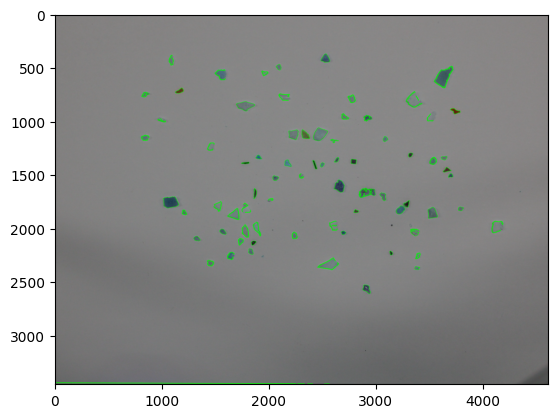

In [7]:
#Carga de imagen de fragmentos
frags = cv2.imread('Material_P3/fragment-03-olympus-10-01-2020.JPG')

#Conversión a escala de grises
if frags is not None:
	frags_gr = cv2.cvtColor(frags, cv2.COLOR_BGR2GRAY)

#Suavizado
frags_gr = cv2.medianBlur(frags_gr, 5)

#Umbralización adaptativa (mejores resultados obtenidos)
frags_th = cv2.adaptiveThreshold(frags_gr, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

#Hallar contornos
contours, hierarchy = cv2.findContours(
	frags_th, 
    cv2.RETR_EXTERNAL, 
    cv2.CHAIN_APPROX_NONE)


#Proceso para filtrar contornos (eliminar ruido y falsos positivos)
frags_copy = frags.copy()

frags_cont = []

for contour in contours:
	if (cv2.arcLength(contour, True) > 100): #Uso de perímetro como factor de comparación 
		frags_cont.append(contour)

#Se dibujan los contornos hallados
cv2.drawContours(frags_copy, frags_cont, -1, (0,255,0), 2, cv2.LINE_AA)

#plt.plot()
#plt.imshow(frags_th, 'grey')
#plt.show()

#Muestra de imagen de fragmentos
plt.plot()
plt.imshow(frags_copy)
plt.show()


##### 1.2. Identificar pellets dentro de una imagen y guardar contornos para más adelante

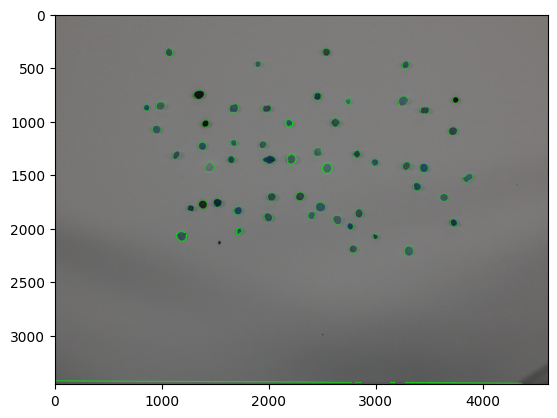

In [8]:
#Carga de imagen de fragmentos
pellets = cv2.imread('Material_P3/pellet-03-olympus-10-01-2020.JPG')

#Conversión a escala de grises
if pellets is not None:
	pellets_gr = cv2.cvtColor(pellets, cv2.COLOR_BGR2GRAY)

pellets_gr = cv2.medianBlur(pellets_gr, 5)

#Umbralización adaptativa (mejores resultados obtenidos)
pellets_th = cv2.adaptiveThreshold(pellets_gr, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

#Hallar contornos
contours, hierarchy = cv2.findContours(
	pellets_th, 
    cv2.RETR_EXTERNAL, 
    cv2.CHAIN_APPROX_NONE)


#Proceso para filtrar contornos (eliminar ruido y falsos positivos)
pellets_copy = pellets.copy()

pellets_cont = []

for contour in contours:
	if (cv2.arcLength(contour, True) > 100): #Uso de perímetro como factor de comparación 
		pellets_cont.append(contour)

#Se dibujan los contornos hallados
cv2.drawContours(pellets_copy, pellets_cont, -1, (0,255,0), 2, cv2.LINE_AA)

#Muestra de imagen de fragmentos
plt.plot()
plt.imshow(pellets_copy)
plt.show()


##### 1.3. Identificar restos de alquitrán dentro de una imagen y guardar contornos para más adelante

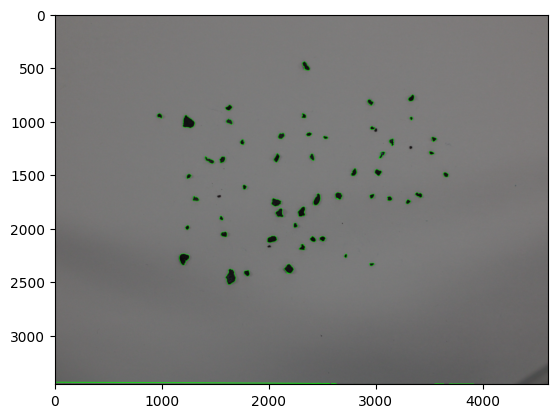

In [9]:
#Carga de imagen de fragmentos
tars = cv2.imread('Material_P3/tar-03-olympus-10-01-2020.JPG')

#Conversión a escala de grises
if tars is not None:
	tars_gr = cv2.cvtColor(tars, cv2.COLOR_BGR2GRAY)

tars_gr = cv2.medianBlur(tars_gr, 5)

#Umbralización adaptativa (mejores resultados obtenidos)
tars_th = cv2.adaptiveThreshold(tars_gr, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

#Hallar contornos
contours, hierarchy = cv2.findContours(
	tars_th, 
    cv2.RETR_EXTERNAL, 
    cv2.CHAIN_APPROX_NONE)


#Proceso para filtrar contornos (eliminar ruido y falsos positivos)
tars_copy = tars.copy()

tars_cont = []

for contour in contours:
	if (cv2.arcLength(contour, True) > 100): #Uso de perímetro como factor de comparación 
		tars_cont.append(contour)

#Se dibujan los contornos hallados
cv2.drawContours(tars_copy, tars_cont, -1, (0,255,0), 2, cv2.LINE_AA)

#Muestra de imagen de fragmentos
plt.plot()
plt.imshow(tars_copy)
plt.show()


##### 2. Extraer características de los contornos hallados

In [10]:
#Se calculan varias características comunes de todos los contornos
def features(contour):
    
    # Obtener momentos de Hu
    hu_moments = cv2.HuMoments(cv2.moments(contour)).flatten()

    # Obtener área y perímetro
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    # Relación área-perímetro
    if perimeter != 0:
        complexity = area / (perimeter ** 2)
    else:
        complexity = 0

    # Bounding rectangle (ancho y alto)
    x, y, w, h = cv2.boundingRect(contour)
    if h != 0:
        aspect_ratio = w / h  # Relación ancho-alto
    else:
        aspect_ratio = 0

    # Obtener el centroide usando momentos
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = 0, 0  # Si no se puede calcular el centroide, asignamos (0,0)

    # Calcular distancias desde el centroide al contorno
    distances = [np.linalg.norm(np.array([cx, cy]) - point[0]) for point in contour]

    if len(distances) > 0:
        min_dist = min(distances)
        max_dist = max(distances)
        if max_dist != 0:
            dist_ratio = min_dist / max_dist  # Relación entre distancia mínima y máxima
        else:
            dist_ratio = 0
    else:
        dist_ratio = 0

    # Combinar todas las características
    features = np.hstack([hu_moments, area, perimeter, complexity, aspect_ratio, dist_ratio])
    return features

# Extraer características de todos los contornos

#Fragmentos de microplásticos
frags_feat = np.array([features(c) for c in frags_cont])

#Pellets
pellets_feat = np.array([features(c) for c in pellets_cont])

#Restos de alquitrán
tars_feat = np.array([features(c) for c in tars_cont])


In [11]:
#Variable de datos
X = np.vstack([frags_feat, pellets_feat, tars_feat])

#Categorías:
Y_frags = np.zeros(len(frags_feat))
Y_pellets = np.ones(len(pellets_feat))
Y_tars = np.full(len(tars_feat), 2)

#Variable de categorías
Y = np.hstack([Y_frags, Y_pellets, Y_tars])


              precision    recall  f1-score   support

         0.0       0.64      0.70      0.67        20
         1.0       0.77      0.74      0.75        27
         2.0       0.67      0.62      0.65        16

    accuracy                           0.70        63
   macro avg       0.69      0.69      0.69        63
weighted avg       0.70      0.70      0.70        63

Semilla con mejor precisión: 13


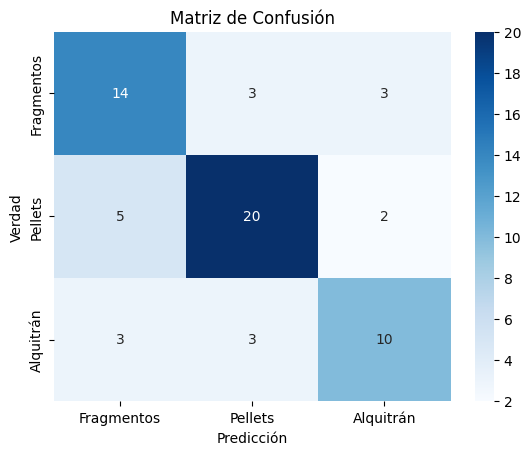

In [12]:
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

b_seed = None
b_pred = 0

for seed in range(0, 50):
	np.random.seed(seed)

	#Dividir los datos en entrenamiento y prueba
	X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

	#Definir y entrenar un clasificador MLP
	mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=3000, random_state=seed)
	mlp.fit(X_train, Y_train)

	#Predecir en el conjunto de prueba
	Y_pred = mlp.predict(X_test)
      
	pred = accuracy_score(Y_test, Y_pred)

	#Si la precisión es la mejor hasta ahora, guardamos el modelo
	if pred > b_pred:
		b_pred = pred
		b_seed = seed

	#Dividir los datos en entrenamiento y prueba con la mejor semilla
	X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=b_seed)

	#Definir y entrenar el clasificador MLP con la mejor semilla
	mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=b_seed)
	mlp.fit(X_train, Y_train)

	#Predecir en el conjunto de prueba
	Y_pred = mlp.predict(X_test)

#Evaluar el rendimiento
print(classification_report(Y_test, Y_pred))

print(f"Semilla con mejor precisión: {b_seed}")

cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(
	cm,
	annot=True,
	fmt="d",
	cmap="Blues",
	xticklabels=['Fragmentos','Pellets','Alquitrán'],
	yticklabels=['Fragmentos','Pellets','Alquitrán']
)

plt.xlabel("Predicción")
plt.ylabel("Verdad")
plt.title("Matriz de Confusión")
plt.show()
